In [ ]:
import numpy as np

# Data Generation
#TODO simulate 5000 times (I forgot oops)
np.random.seed(420)
N = 100
k = 10
rhos = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 0.95])
a_s = [0.45, 0.35, 0.25, 0.2, 0.15, 0.1, 0.05, 0]
eps_a = {}
V_a = {}
Pi_a = {}
Z_a = {}
X_a = {}
Y_a = {}
for a in a_s:
    eps = np.zeros([N, 10])
    V = np.zeros([N, 10])
    Pi = np.array([a] + [0] * (k-1))
    for i, rho in enumerate(rhos):
        Sigma = np.array([[1, rho], [rho, 1]])
        errors = np.random.multivariate_normal(mean=[0, 0], cov=Sigma, size=N)
        eps[:, i] = errors[:, 0]
        V[:, i] = errors[:, 1]
    Z = np.random.normal(size=N*k*10).reshape([10, N, k])
    X = np.zeros([N, 10])
    for i, mat in enumerate(Z):
        X[:, i] = mat @ Pi
    X += V
    Y = eps # Under H0
    eps_a[a] = eps
    V_a[a] = V
    Pi_a[a] = Pi
    Z_a[a] = Z
    X_a[a] = X
    Y_a[a] = Y

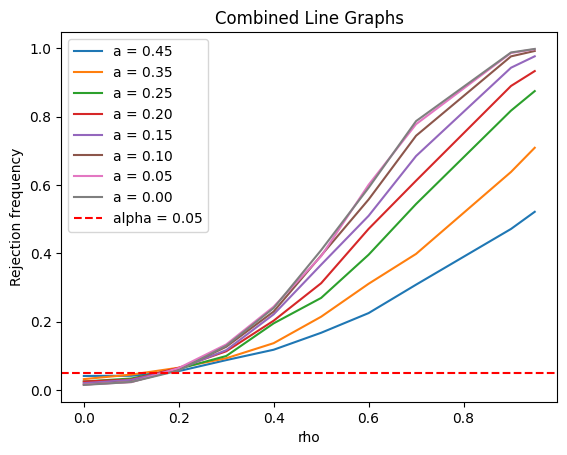

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Set parameters
np.random.seed(123)
N = 100
k = 10
simulations = 5000
alpha=0.05
CV_upper = stats.t.ppf(1-alpha/2,N-1)
CV_lower = stats.t.ppf(alpha/2,N-1)

rhos = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 0.95]
a_s = [0.45, 0.35, 0.25, 0.2, 0.15, 0.1, 0.05, 0]
Z = np.random.randn(N, k)

def rejection_frequency(a,rho):

  # Set parameters
  rejection_count = 0
  cov_matrix = np.array([[1, rho],
                      [rho, 1]])
  Pi = a * np.array([1] + [0] * 9)

  # Start simulations
  for i in range(simulations):

    # Generate data
    df = np.random.multivariate_normal([0, 0], cov_matrix, N)
    eps = df[:,0].reshape(100,1)
    V = df[:,1].reshape(100,1)


    # Model data
    z_pi = (Z@Pi).reshape(-1,1)
    X = z_pi + V
    Y = X*0 + eps

    # Perform 2SLS
    # First stage
    Pi_hat = np.linalg.inv(Z.T @ Z) @ (Z.T@X)
    Pz = Z @ np.linalg.inv(Z.T @ Z) @ Z.T

    # Second stage
    b_2SLS = np.linalg.inv(X.T @ Pz @ X) @ (X.T @ Pz @ Y)

    #Standard error for 2SLS
    res_2SLS = Y-X@b_2SLS
    s2_2SLS = (res_2SLS.T @ res_2SLS)/(N-1)
    SE_2SLS = np.sqrt(s2_2SLS*np.linalg.inv(X.T @ Pz @ X))

    # Calculate t-statistic
    t_stat = b_2SLS/SE_2SLS
    if t_stat > CV_upper or t_stat < CV_lower:
        rejection_count += 1

  return rejection_count/simulations

# Calculate rejection frequency for
df = pd.DataFrame(np.zeros((len(a_s), len(rhos))), index = a_s, columns = rhos)
for i,a in enumerate(a_s):
  df.iloc[i,:] = [rejection_frequency(a,rho) for rho in rhos]

# Plot rejection frequency as a function of rho for each a
plt.plot(rhos, df.iloc[0,:], label='a = 0.45')
plt.plot(rhos, df.iloc[1,:], label='a = 0.35')
plt.plot(rhos, df.iloc[2,:], label='a = 0.25')
plt.plot(rhos, df.iloc[3,:], label='a = 0.20')
plt.plot(rhos, df.iloc[4,:], label='a = 0.15')
plt.plot(rhos, df.iloc[5,:], label='a = 0.10')
plt.plot(rhos, df.iloc[6,:], label='a = 0.05')
plt.plot(rhos, df.iloc[7,:], label='a = 0.00')
plt.axhline(y=0.05, color='red', linestyle='--', label='alpha = 0.05')


# Add labels, legend, and title
plt.xlabel('rho')
plt.ylabel('Rejection frequency')
plt.legend()
plt.title('Combined Line Graphs')

# Display the plot
plt.show()

In [ ]:
# Exercise 2
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

np.random.seed(420)
r_bs = np.arange(500)
k = 10
S = 10000
G = len(r_bs)
psi_1 = np.random.chisquare(1, G * S).reshape([S, G])
psi_k1 = np.random.chisquare(k-1, G * S).reshape([S, G])
LR = 0.5 * (psi_k1 + psi_1 - r_bs + np.sqrt((psi_k1 + psi_1 + r_bs)**2 - 4 * r_bs * psi_k1))
CV = np.quantile(LR, 0.95, axis=0)

fig = px.line(y=CV, labels={'y': 'Critical Value', 'x': 'r(B)'}, title='95% Critical Value Function of LR Statistic')

fig.add_trace(go.Scatter(
    x=[0, len(r_bs)],
    y=[stats.chi2(10).ppf(0.95), stats.chi2(10).ppf(0.95)],
    mode='lines',
    line=dict(dash='dash'),
    name='Chi2(10) 0.95'
))

fig.add_trace(go.Scatter(
    x=[0, len(r_bs)],
    y=[stats.chi2(1).ppf(0.95), stats.chi2(1).ppf(0.95)],
    mode='lines',
    line=dict(dash='dash'),
    name='Chi2(1) 0.95'
))

fig.show()

As can be seen in the plot provided, the critical value of the LR statistic when $r(\beta_0)=0$ is approximately the $95\%$ critical value of a $\chi^2(10)(=18.31)$ distributed random variable, whereas the critical value of the LR statistic when $r(\beta_0)=\infty$ is approximately the $95\%$ critical value of a $\chi^2(1) (=3.84)$ distributed random variable

In [ ]:
# Exercise 4
np.random.seed(420)
r_bs = np.arange(500)
k = 3
S = 50000
G = len(r_bs)
psi_1 = np.random.chisquare(1, G * S).reshape([S, G])
psi_k1 = np.random.chisquare(k-1, G * S).reshape([S, G])
LR = 0.5 * (psi_k1 + psi_1 - r_bs + np.sqrt((psi_k1 + psi_1 + r_bs)**2 - 4 * r_bs * psi_k1))
CV = np.quantile(LR, 0.95, axis=0)

fig = px.line(y=CV, labels={'y': 'Critical Value', 'x': 'r(B)'}, title='95% Critical Value Function of LR Statistic')

fig.show()

In [ ]:
import pandas as pd
df = pd.read_csv('assignmentweakinstruments.csv')

Question 5


In [ ]:

import statsmodels.api as sm

# Assuming 'education' is the endogenous variable, 'nearc2' is the instrument,
# and 'exog_vars' are other exogenous variables

# First Stage Regression
first_stage = sm.OLS(endog=df['ed'], exog=sm.add_constant(df[['nearc2']])).fit()
predicted_education = first_stage.predict()

# Second Stage Regression
second_stage = sm.OLS(endog=df['wage'], exog=sm.add_constant(predicted_education)).fit()

# 2SLS t-Statistic for the return on education
t_stat = second_stage.tvalues['x1']

# Calculate 95% Confidence Interval
alpha = 0.05
confidence_interval = second_stage.conf_int(alpha=alpha)

# AR Statistic
ar_statistic, ar_p_value, _, _ = sm.stats.diagnostic.het_arch(second_stage.resid)

# Display Results
print("2SLS t-Statistic:", t_stat)
print("95% Confidence Interval for the Return on Education:")
print(confidence_interval)
print("AR Statistic:", ar_statistic)
print("P-value for AR Statistic:", ar_p_value)


2SLS t-Statistic: 5.403253347583219
95% Confidence Interval for the Return on Education:
              0         1
const  0.056549  3.361118
x1     0.218705  0.467842
AR Statistic: 19.12818666440408
P-value for AR Statistic: 0.03866440278101283


In [ ]:
import plotly.express as px
# Exercise 5
# df = pd.read_csv('assignmentweakinstruments.csv')
exo_cols = ['exper', 'exper2', 'south', 'smsa', 'race']
instruments = ['nearc2']
exo_values = df[exo_cols]
exo_values['constant'] = 1
exo = exo_values.to_numpy()
N = df.shape[0]
k = len(instruments)
y = (np.eye(N) - exo@np.linalg.inv(exo.T@exo)@exo.T)@df['wage'].values
X = (np.eye(N) - exo@np.linalg.inv(exo.T@exo)@exo.T)@df['ed'].values
Z = (np.eye(N) - exo@np.linalg.inv(exo.T@exo)@exo.T)@df[instruments].values.reshape(N, k)

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def anderson_rubin(y, X, Z, B_0):
    N = Z.shape[0]
    k = Z.shape[1]
    numerator = (y - X*B_0).T @ (Z@np.linalg.inv(Z.T@Z)@Z.T) @ (y - X*B_0).T / k
    denominator = (y - X*B_0).T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ (y - X*B_0).T / (N - k)
    return numerator / denominator

#X = df['ed'].values
#y = df['wage'].values
#Z = df['nearc2'].values.reshape(df.shape[0], 1)
Betas = np.linspace(-2, 2, int((2 - (-2)) / 0.01) + 1)
ARs = [anderson_rubin(y, X, Z, b) for b in Betas]
AR_df = pd.DataFrame({'B_0': Betas, 'AR_stat': ARs})

# Calculate 95% critical chi-squared value for 1 degree of freedom
critical_value = 3.841  # You can use the scipy.stats.chi2.ppf function for a more accurate value

# Plotting
fig = px.line(AR_df, x='B_0', y='AR_stat', title='Anderson-Rubin Function')

# Add a red line for the critical chi-squared value
fig.add_trace(go.Scatter(x=[-2, 2], y=[critical_value, critical_value], mode='lines', name='Critical Value', line=dict(color='red')))

fig.show()


<ipython-input-8-ced93926b7d7>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# b)


We see from the graph that when using just one instrument, the confidence set using the AR statistic (which we know to be reliable when there are weak instruments), is unbounded and disjoint, which is a sign that the instruments are weak!
Furthermore we see that the confidence set of the 2SLS t-statistic is different. We have learnt from theory that when there are weak instruments, the distributions of B_2SLS is highly non normal and therefore the confidence set corresponding to the asymptotic crititcal t-values will result in unreliable results.

# c)

In [ ]:
# C)
import statsmodels.api as sm
# First Stage Regression
df = pd.read_csv('assignmentweakinstruments.csv')
first_stage = sm.OLS(endog=df['ed'], exog=sm.add_constant(df[['nearc2']])).fit()
F_stat = first_stage.fvalue
print(f'The first stage F-statistic is given by: {F_stat}')

The first stage F-statistic is given by: 6.759437565124665




When B becomes very large, from the graph we can see that the value of the AR statistic seems to converge to an asymptotic limit of about 2.5 in the positive direction and about -3 in the negative direction, so it would be reasonable to say the asymptotic limit lies somewhere at AR = 2.75
To prove this we can just plug a big value of beta in to the formula for the AR statistic:

In [ ]:
print(anderson_rubin(y, X, Z, 1000))
print(anderson_rubin(y, X, Z, -1000))

2.808912129805165
2.812015018104713


Note that the first stage F-statistic < 10, which means the instruments are weak and therefore B_2SLS will be non normal and give unreliable confidence sets using the corresponding t-statistic - this is in line with our conclusion in b).

# d)


The LM test is equal to the AR statistic when there's only one instrument in the model, so yes, this has been used in a) already.

The same happens for the LR statistic, which is also equal to the AR statistic when one instrument is used:

$LR(B_0) = 0.5[kAR(B_0)-r(B_0) + \sqrt{(kAR(B_0) +r(B_0))^2 - 4r(B_0)[kAR(B_0) - LM(B_0)]}] = 0.5[kAR(B_0)-r(B_0) + \sqrt{(kAR(B_0) +r(B_0))^2 - 4r(B_0)*0}] = 0.5[kAR(B_0)-r(B_0) + (kAR(B_0) +r(B_0))] = 0.5[2AR(B_0)] = AR(B_o)$



In [ ]:
# Exercise 5
# df = pd.read_csv('assignmentweakinstruments.csv')
exo_cols = ['exper', 'exper2', 'south', 'smsa', 'race']
instruments = ['nearc4', 'nearc2', 'nearc4a']
exo_values = df[exo_cols]
exo_values['constant'] = 1
exo = exo_values.to_numpy()
N = df.shape[0]
k = len(instruments)
y = (np.eye(N) - exo@np.linalg.inv(exo.T@exo)@exo.T)@df['wage'].values
X = (np.eye(N) - exo@np.linalg.inv(exo.T@exo)@exo.T)@df['ed'].values
Z = (np.eye(N) - exo@np.linalg.inv(exo.T@exo)@exo.T)@df[instruments].values.reshape(N, k)


<ipython-input-13-0ffdfb083c9f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# e)

In [ ]:

# 2SLS
alpha = 0.05
from statsmodels.sandbox.regression.gmm import IV2SLS
import scipy.stats as stats

test_2sls = IV2SLS(y, X, Z).fit()
print(f'Confidence interval using 2SLS statistic: {test_2sls.conf_int(alpha)[0]}')

# AR
crit_value = stats.chi2.ppf(1-alpha, k) / k
Betas = np.linspace(0, 1, 1001)
ARs = np.array([anderson_rubin(y, X, Z, b) for b in Betas])
no_rej_region = Betas[ARs <= crit_value]
print(f'Confidence interval using Anderson-Rubin statistic: {no_rej_region[0], no_rej_region[-1]}')

# LM
crit_value = stats.chi2.ppf(1-alpha, 1)
def lagrange_multiplier(y, X, Z, B_0): # aka score
    N = Z.shape[0]
    k = Z.shape[1]
    eps = y - X*B_0
    sigma_hat_eV = 1/(N-k) * eps.T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ X
    sigma_hat_ee = 1/(N-k) * eps.T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ eps
    rho_hat = sigma_hat_eV / sigma_hat_ee
    pi_hat = np.linalg.inv(Z.T@Z)@Z.T@(X - eps*rho_hat) # Estimator for pi
    P_Zpi = (Z@pi_hat).reshape(N, 1) @ np.linalg.inv((pi_hat.T@Z.T).reshape(1, N) @ (Z@pi_hat).reshape(N, 1)) @ (pi_hat.T@Z.T).reshape(1, N)
    LM = (1/sigma_hat_ee) * eps.T @ P_Zpi @ eps
    return LM

LMs = np.array([lagrange_multiplier(y, X, Z, b) for b in Betas])
no_rej_region = Betas[LMs <= crit_value]
print(f'Confidence interval using Lagrange-Multiplier/Score statistic: {no_rej_region[0], no_rej_region[-1]}')

# LM
def likelihood_ratio(y, X, Z, B_0):
    N = Z.shape[0]
    k = Z.shape[1]
    eps = y - X*B_0
    sigma_hat_eV = 1/(N-k) * eps.T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ X
    sigma_hat_Ve = 1/(N-k) * X.T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ eps
    sigma_hat_ee = 1/(N-k) * eps.T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ eps
    Sigma_hat_VV = 1/(N-k) * X.T @ (np.eye(N) - Z@np.linalg.inv(Z.T@Z)@Z.T) @ X
    Sigma_hat_VV_e = Sigma_hat_VV - sigma_hat_Ve*sigma_hat_eV / sigma_hat_ee
    rho_hat = sigma_hat_eV / sigma_hat_ee
    pi_hat = np.linalg.inv(Z.T@Z)@Z.T@(X - eps*rho_hat) # Estimator for pi
    P_Zpi = (Z@pi_hat).reshape(N, 1) @ np.linalg.inv((pi_hat.T@Z.T).reshape(1, N) @ (Z@pi_hat).reshape(N, 1)) @ (pi_hat.T@Z.T).reshape(1, N)
    r_B = 1/Sigma_hat_VV_e * pi_hat.T @ Z.T @ Z @pi_hat
    kAR_B = 1/sigma_hat_ee * eps.T @ (Z@np.linalg.inv(Z.T@Z)@Z.T) @ eps
    LM_B = 1/sigma_hat_ee * eps.T @ P_Zpi @ eps
    LR_B = 0.5 * (kAR_B - r_B + np.sqrt((kAR_B + r_B)**2 - 4*r_B*(kAR_B - LM_B)))
    return LR_B, r_B

r_bs = np.arange(0, 50, 0.01)
k = 3
S = 10000
G = len(r_bs)
psi_1 = np.random.chisquare(1, G * S).reshape([S, G])
psi_k1 = np.random.chisquare(k-1, G * S).reshape([S, G])
LR_dist = 0.5 * (psi_k1 + psi_1 - r_bs + np.sqrt((psi_k1 + psi_1 + r_bs)**2 - 4 * r_bs * psi_k1))
CV = np.quantile(LR_dist, 0.95, axis=0)
CV_df = pd.DataFrame({'r_B': np.round(r_bs, 2), 'CV': CV}).set_index('r_B')

output = [likelihood_ratio(y, X, Z, b) for b in Betas]
LRs, r_Bs = zip(*output)
r_Bs = np.round(r_Bs, 2)
crit_values = CV_df.loc[r_Bs]['CV'].values
no_rej_region = Betas[np.array(LRs) <= crit_values]
print(f'Confidence interval using Likelihood-Ratio statistic: {no_rej_region[0], no_rej_region[-1]}')

Confidence interval using 2SLS statistic: [0.09074327 0.25124254]
Confidence interval using Anderson-Rubin statistic: (0.094, 0.324)
Confidence interval using Lagrange-Multiplier/Score statistic: (0.10200000000000001, 0.303)
Confidence interval using Likelihood-Ratio statistic: (0.10400000000000001, 0.3)


# f)

We know that if we have weak instruments, the 2SLS estimator is highly non normal and therefore the t statistic is also. The criticial t-values are completely unreliable if the distribution of the t-statistic is not close to the standard normal distribution.

The LM confidence set is narrower than AR

The AR confidence set is wider, this is because the limiting distribution (chi-square) has 3 degrees of freedom compared to only 1 d.o.f. for the LM statistic. This is a disadvantage of the AR statistic as it "wastes" power. Compared to the LM stat it will reject H0 on a smaller set of values than the LM stat.